## Project Overview: 
In 2012, CMS began reducing Medicare payments for subsection(d) hospitals with excess readmissions under the Hospital Readmission Reduction Program. Excess readmissions are measured by a ratio, calculated by dividing a hospital's predicted Readmission Rate (RR) for heart attack, heart failure, pneumonia, chronic obstructive pulmonary disease, hip/knee replacement, and coronary artery bypass graft surgery by expected RR, based on an average hospital with similar patients.

We have been approached by leadership of a medium-large sized (approx. 2,700 Medicare reimbursed inpatient cases per year) public hospital in New Jersey. In their annual review, CMS flagged the hospital as having a higher than expected RR and informed them they would be subject to reduced payments in 1 year if this rate (approx. 17%) did not improve by 1% to align with what CMS expects given their own model’s assumptions. 
 
The hospital’s leadership wants us to help then conduct their own analysis of factors most related to RR in hospitals of comparable size, and then come up with an evidence-driven plan to avoid a penalty that they have determined would substantially affect their ability to provide quality care. Even if the analysis reveals that factors largely out of their control (e.g., demographics in the area of the hospital, case volume, case mix) are responsible for their higher than expected RR rate according to CMS, the hospital administrators feel that this can be baked into a reply letter to CMS that may help forestall a reduction in Medicare reimbursement that would certainly negatively impact care at the facility.

In the previous step (see workbook 01_CleaningWrangling), we cleaned and wrangled data into several discrete dataframes. 

## Exploratory Data Analysis

### 1. Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder #to handle categorical variables (ED_Volume)
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import scale

### 2. Load Data
Main data table and additional data from cleaning and wrangling - includes candidate predictive features and target feature (Readmission Rate) 

In [2]:
#Includes all hospitals with at least 200 inpatient cases in the previous year (and also reported target data)
main_data = pd.read_csv('../data/main_df_post1_200.csv')
supp_data = pd.read_csv('../data/other_data_post1_200.csv')

### 3. Summaries of data

In [3]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Facility_ID           2473 non-null   object 
 1   City                  2473 non-null   object 
 2   State                 2473 non-null   object 
 3   County                2473 non-null   object 
 4   Total_Admissions      2473 non-null   int64  
 5   ReadmissionRate       2473 non-null   float64
 6   HAI_1_SIR             1949 non-null   float64
 7   HAI_2_SIR             2133 non-null   float64
 8   HAI_5_SIR             1674 non-null   float64
 9   HAI_6_SIR             2320 non-null   float64
 10  PSI_3                 2445 non-null   float64
 11  PSI_6                 2445 non-null   float64
 12  PSI_8                 2445 non-null   float64
 13  PSI_9                 2436 non-null   float64
 14  PSI_10                2335 non-null   float64
 15  PSI_11               

In [4]:
main_data.head()

,Facility_ID,City,State,County,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,...,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT
0,10001,DOTHAN,AL,Houston,1805,15.5,0.555,0.289,0.871,0.604,...,0.091413,0.278670,168.0,3.0,high,60.0,99.0,44661.000000,105882.0,40.0
1,10005,BOAZ,AL,Marshall,764,14.7,1.650,1.055,2.780,0.601,...,0.219895,0.612565,139.0,2.0,very high,60.0,93.0,37982.666667,96774.0,38.9
2,10006,FLORENCE,AL,Lauderdale,1563,15.7,0.987,0.442,1.232,0.212,...,0.195777,0.424184,182.0,1.0,high,32.0,82.0,38525.333333,92729.0,41.6
3,10011,BIRMINGHAM,AL,Jefferson,918,16.3,0.424,0.993,0.802,0.359,...,0.046841,0.380174,174.0,3.0,high,30.0,76.0,56600.000000,658573.0,37.9
4,10012,FORT PAYNE,AL,DeKalb,265,15.6,NaN,0.000,NaN,0.493,...,0.109434,NaN,170.0,3.0,medium,80.0,82.0,33574.333333,71513.0,40.1


In [5]:
#A quick look at distributions of feature values for the numeric features 
main_data.describe()

,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,PSI_3,PSI_6,PSI_8,PSI_9,...,HF_TA_PROP,HIPKNEE_TA_PROP,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT
count,2473.000000,2473.000000,1949.000000,2133.000000,1674.000000,2320.000000,2445.000000,2445.000000,2445.000000,2436.000000,...,2420.000000,2084.000000,2397.000000,2308.000000,1796.000000,2255.000000,2325.000000,2472.000000,2.473000e+03,2473.000000
mean,1064.822887,15.526243,0.925993,0.800683,0.925553,0.528156,0.573317,0.230914,0.095690,2.541132,...,0.393024,0.273980,0.427675,168.012132,1.610245,57.419956,84.872258,55631.604504,9.441677e+05,38.936029
std,902.931375,0.829070,0.815891,0.631669,0.751351,0.338832,0.561320,0.038537,0.008002,0.378202,...,0.122075,0.183334,0.167607,40.587470,1.647345,17.288272,14.464704,17684.935419,1.717654e+06,4.424676
min,201.000000,11.500000,0.000000,0.000000,0.000000,0.000000,0.037901,0.124230,0.070426,1.257119,...,0.060606,0.011865,0.037855,64.000000,0.000000,3.000000,6.000000,28750.333333,6.347000e+03,22.200000
25%,426.000000,15.000000,0.447000,0.395000,0.448000,0.299000,0.255734,0.208941,0.091327,2.334644,...,0.310610,0.139651,0.309197,140.000000,1.000000,45.000000,78.000000,44667.000000,1.098620e+05,36.300000
50%,799.000000,15.500000,0.776000,0.704000,0.791000,0.490500,0.398914,0.222518,0.093647,2.479184,...,0.384077,0.227998,0.404982,163.000000,1.000000,58.000000,89.000000,51950.166667,3.674300e+05,38.500000
75%,1396.000000,16.000000,1.226000,1.056000,1.257000,0.697000,0.694559,0.247689,0.099546,2.703189,...,0.464945,0.362081,0.524862,190.000000,2.000000,70.000000,96.000000,63317.000000,9.362500e+05,41.100000
max,9065.000000,21.200000,8.467000,5.296000,5.401000,3.139000,8.784577,0.480232,0.158638,5.581095,...,0.994881,0.995321,0.985294,386.000000,27.000000,100.000000,100.000000,220498.666667,1.003911e+07,60.100000


### 4. Feature Generation
Something potentially useful to explicitly capture as a feature is a direct measure of inpatient facility density per person. This, along with 1) inpatient caseload/case mix per hospital; 2) ED caseload/efficiency; and 3) raw population per county, will help round out a picture of how "burdened" hospitals in our sample are. We will create this feature by computing the ratio of inpatient facilities within the county that a facility is to the population of the county (county population/# hospitals in the county; pop_per_hosp) 

In [6]:
#Create a count of facilities per county and add to main_data (now main_data2) 
county_hospitals = main_data.groupby(["State", "County"]).size().reset_index(name="County_Facilities")
main_data2 = pd.merge(main_data, county_hospitals, how='left', on=['State','County'])
main_data2.rename(columns = {'Facilities':'County_Facilities'}, inplace=True)
main_data2.head(30)

,Facility_ID,City,State,County,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,...,PN_TA_PROP,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT,County_Facilities
0,10001,DOTHAN,AL,Houston,1805,15.5,0.555,0.289,0.871,0.604,...,0.278670,168.0,3.0,high,60.0,99.0,44661.000000,105882.0,40.0,2
1,10005,BOAZ,AL,Marshall,764,14.7,1.650,1.055,2.780,0.601,...,0.612565,139.0,2.0,very high,60.0,93.0,37982.666667,96774.0,38.9,1
2,10006,FLORENCE,AL,Lauderdale,1563,15.7,0.987,0.442,1.232,0.212,...,0.424184,182.0,1.0,high,32.0,82.0,38525.333333,92729.0,41.6,1
3,10011,BIRMINGHAM,AL,Jefferson,918,16.3,0.424,0.993,0.802,0.359,...,0.380174,174.0,3.0,high,30.0,76.0,56600.000000,658573.0,37.9,8
4,10012,FORT PAYNE,AL,DeKalb,265,15.6,NaN,0.000,NaN,0.493,...,NaN,170.0,3.0,medium,80.0,82.0,33574.333333,71513.0,40.1,1
5,10016,ALABASTER,AL,Shelby,808,15.4,0.315,0.547,0.847,0.498,...,0.360149,208.0,2.0,medium,63.0,94.0,57621.000000,217702.0,39.8,1
6,10019,SHEFFIELD,AL,Colbert,778,15.8,2.572,0.706,2.092,0.455,...,0.421594,135.0,1.0,medium,78.0,90.0,39467.333333,55241.0,42.3,1
7,10023,MONTGOMERY,AL,Montgomery,1165,15.0,2.080,1.568,2.985,0.638,...,0.150215,185.0,NaN,NaN,11.0,93.0,45271.666667,226486.0,36.8,3
8,10024,MONTGOMERY,AL,Montgomery,1011,16.1,1.537,0.974,2.191,1.168,...,0.348170,126.0,1.0,very high,73.0,53.0,45271.666667,226486.0,36.8,3
9,10029,OPELIKA,AL,Lee,1196,14.8,1.030,0.920,0.946,0.662,...,0.296823,200.0,NaN,NaN,65.0,89.0,40363.666667,164542.0,32.8,1


In [7]:
#Let's look at inpatient facilities per county for a second
binning = pd.concat([county_hospitals.County_Facilities.value_counts(normalize=True, sort = False, bins = [0, 5, 10, 15, 20, 25, 30]),
                county_hospitals.County_Facilities.value_counts(sort = False, bins = [0, 5, 10, 15, 20, 25, 30])], 
                axis=1,
                keys=('perc','count'))
print (binning)

                   perc  count
(-0.001, 5.0]  0.919295    991
(5.0, 10.0]    0.058442     63
(10.0, 15.0]   0.014842     16
(15.0, 20.0]   0.003711      4
(20.0, 25.0]   0.000928      1
(25.0, 30.0]   0.000928      1


In [8]:
#Create desired ratio (population per hospital, given county hospital totals just tabulated)
main_data2["Pop/Hosp"] = main_data2["Population_2019"] / main_data2["County_Facilities"]
main_data2.head(30)

,Facility_ID,City,State,County,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,...,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT,County_Facilities,Pop/Hosp
0,10001,DOTHAN,AL,Houston,1805,15.5,0.555,0.289,0.871,0.604,...,168.0,3.0,high,60.0,99.0,44661.000000,105882.0,40.0,2,52941.000000
1,10005,BOAZ,AL,Marshall,764,14.7,1.650,1.055,2.780,0.601,...,139.0,2.0,very high,60.0,93.0,37982.666667,96774.0,38.9,1,96774.000000
2,10006,FLORENCE,AL,Lauderdale,1563,15.7,0.987,0.442,1.232,0.212,...,182.0,1.0,high,32.0,82.0,38525.333333,92729.0,41.6,1,92729.000000
3,10011,BIRMINGHAM,AL,Jefferson,918,16.3,0.424,0.993,0.802,0.359,...,174.0,3.0,high,30.0,76.0,56600.000000,658573.0,37.9,8,82321.625000
4,10012,FORT PAYNE,AL,DeKalb,265,15.6,NaN,0.000,NaN,0.493,...,170.0,3.0,medium,80.0,82.0,33574.333333,71513.0,40.1,1,71513.000000
5,10016,ALABASTER,AL,Shelby,808,15.4,0.315,0.547,0.847,0.498,...,208.0,2.0,medium,63.0,94.0,57621.000000,217702.0,39.8,1,217702.000000
6,10019,SHEFFIELD,AL,Colbert,778,15.8,2.572,0.706,2.092,0.455,...,135.0,1.0,medium,78.0,90.0,39467.333333,55241.0,42.3,1,55241.000000
7,10023,MONTGOMERY,AL,Montgomery,1165,15.0,2.080,1.568,2.985,0.638,...,185.0,NaN,NaN,11.0,93.0,45271.666667,226486.0,36.8,3,75495.333333
8,10024,MONTGOMERY,AL,Montgomery,1011,16.1,1.537,0.974,2.191,1.168,...,126.0,1.0,very high,73.0,53.0,45271.666667,226486.0,36.8,3,75495.333333
9,10029,OPELIKA,AL,Lee,1196,14.8,1.030,0.920,0.946,0.662,...,200.0,NaN,NaN,65.0,89.0,40363.666667,164542.0,32.8,1,164542.000000


We have one categorical variable that it would be good to transform before doing some visualization-ER Volume. While we could do one-hot encoding here, let's stay efficient and encode levels numerically in a single column with numeric level encoding.

In [9]:
main_data2['ED_VOLUME'].value_counts()

medium       616
very high    556
high         436
low          188
Name: ED_VOLUME, dtype: int64

In [10]:
main_data2['ED_VOLUME'].isnull().value_counts()

False    1796
True      677
Name: ED_VOLUME, dtype: int64

In [11]:
#Let's set the NaNs to 'Missing' so we can use OrdinalEncoder
main_data2['ED_VOLUME'] = main_data2['ED_VOLUME'].fillna('Missing')
main_data2['ED_VOLUME'].value_counts()

Missing      677
medium       616
very high    556
high         436
low          188
Name: ED_VOLUME, dtype: int64

In [12]:
main_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Facility_ID           2473 non-null   object 
 1   City                  2473 non-null   object 
 2   State                 2473 non-null   object 
 3   County                2473 non-null   object 
 4   Total_Admissions      2473 non-null   int64  
 5   ReadmissionRate       2473 non-null   float64
 6   HAI_1_SIR             1949 non-null   float64
 7   HAI_2_SIR             2133 non-null   float64
 8   HAI_5_SIR             1674 non-null   float64
 9   HAI_6_SIR             2320 non-null   float64
 10  PSI_3                 2445 non-null   float64
 11  PSI_6                 2445 non-null   float64
 12  PSI_8                 2445 non-null   float64
 13  PSI_9                 2436 non-null   float64
 14  PSI_10                2335 non-null   float64
 15  PSI_11               

In [13]:
#Using scikit learn OrdinalEncoder, numerically encode ED_VOLUME
# 0=Missing; 1=low; 2=medium; 3=high; 4=very high
vol_categories = ['Missing','low', 'medium', 'high','very high']

encoder = OrdinalEncoder(categories=[vol_categories])
main_data2['ED_VOLUME'] = encoder.fit_transform(main_data2[['ED_VOLUME']])

In [14]:
main_data2['ED_VOLUME'].value_counts()

0.0    677
2.0    616
4.0    556
3.0    436
1.0    188
Name: ED_VOLUME, dtype: int64

In [15]:
main_data2.head()

,Facility_ID,City,State,County,Total_Admissions,ReadmissionRate,HAI_1_SIR,HAI_2_SIR,HAI_5_SIR,HAI_6_SIR,...,ED_MEDIAN_VISIT_MINS,ED_LEFT_NOT_SEEN_%,ED_VOLUME,%_SEPSIS_CARE,%_HCWs_FLU_VAX,2018to2020_PCPI,Population_2019,MEDIAN_AGE_TOT,County_Facilities,Pop/Hosp
0,10001,DOTHAN,AL,Houston,1805,15.5,0.555,0.289,0.871,0.604,...,168.0,3.0,3.0,60.0,99.0,44661.000000,105882.0,40.0,2,52941.000
1,10005,BOAZ,AL,Marshall,764,14.7,1.650,1.055,2.780,0.601,...,139.0,2.0,4.0,60.0,93.0,37982.666667,96774.0,38.9,1,96774.000
2,10006,FLORENCE,AL,Lauderdale,1563,15.7,0.987,0.442,1.232,0.212,...,182.0,1.0,3.0,32.0,82.0,38525.333333,92729.0,41.6,1,92729.000
3,10011,BIRMINGHAM,AL,Jefferson,918,16.3,0.424,0.993,0.802,0.359,...,174.0,3.0,3.0,30.0,76.0,56600.000000,658573.0,37.9,8,82321.625
4,10012,FORT PAYNE,AL,DeKalb,265,15.6,NaN,0.000,NaN,0.493,...,170.0,3.0,2.0,80.0,82.0,33574.333333,71513.0,40.1,1,71513.000


In [16]:
main_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Facility_ID           2473 non-null   object 
 1   City                  2473 non-null   object 
 2   State                 2473 non-null   object 
 3   County                2473 non-null   object 
 4   Total_Admissions      2473 non-null   int64  
 5   ReadmissionRate       2473 non-null   float64
 6   HAI_1_SIR             1949 non-null   float64
 7   HAI_2_SIR             2133 non-null   float64
 8   HAI_5_SIR             1674 non-null   float64
 9   HAI_6_SIR             2320 non-null   float64
 10  PSI_3                 2445 non-null   float64
 11  PSI_6                 2445 non-null   float64
 12  PSI_8                 2445 non-null   float64
 13  PSI_9                 2436 non-null   float64
 14  PSI_10                2335 non-null   float64
 15  PSI_11               

In [17]:
#One-hot encoding of ER volume. Ordinal Encoding is the preferred approach (this isn't a nominal enconding task anyhow), but code left here for reference.

#ED_Volume is qualitative categories at this point. Let's convert to numerical encoding.
# get the dummies and store it in a variable
#dummies = pd.get_dummies(df.ED_VOLUME)
 
# Concatenate the dummies to original dataframe
#df = pd.concat([df, dummies], axis='columns')
 
# drop the values
#df.drop(['ED_VOLUME'], axis='columns', inplace=True)

#rename numerically encoded ED_VOLUME
#df.rename(columns = {'high':'ED_VOLUME_HIGH'}, inplace=True)
#df.rename(columns = {'low':'ED_VOLUME_LOW'}, inplace=True)
#df.rename(columns = {'medium':'ED_VOLUME_MED'}, inplace=True)
#df.rename(columns = {'very high':'ED_VOLUME_VHIGH'}, inplace=True)
# print the dataframe
#df.head(20)

### 5. Data Visualization

In [18]:
# move target (ReadmissionRate) to first position for ease of visualization in heat map
first_column = main_data2.pop('ReadmissionRate')
main_data2.insert(0, 'ReadmissionRate', first_column)

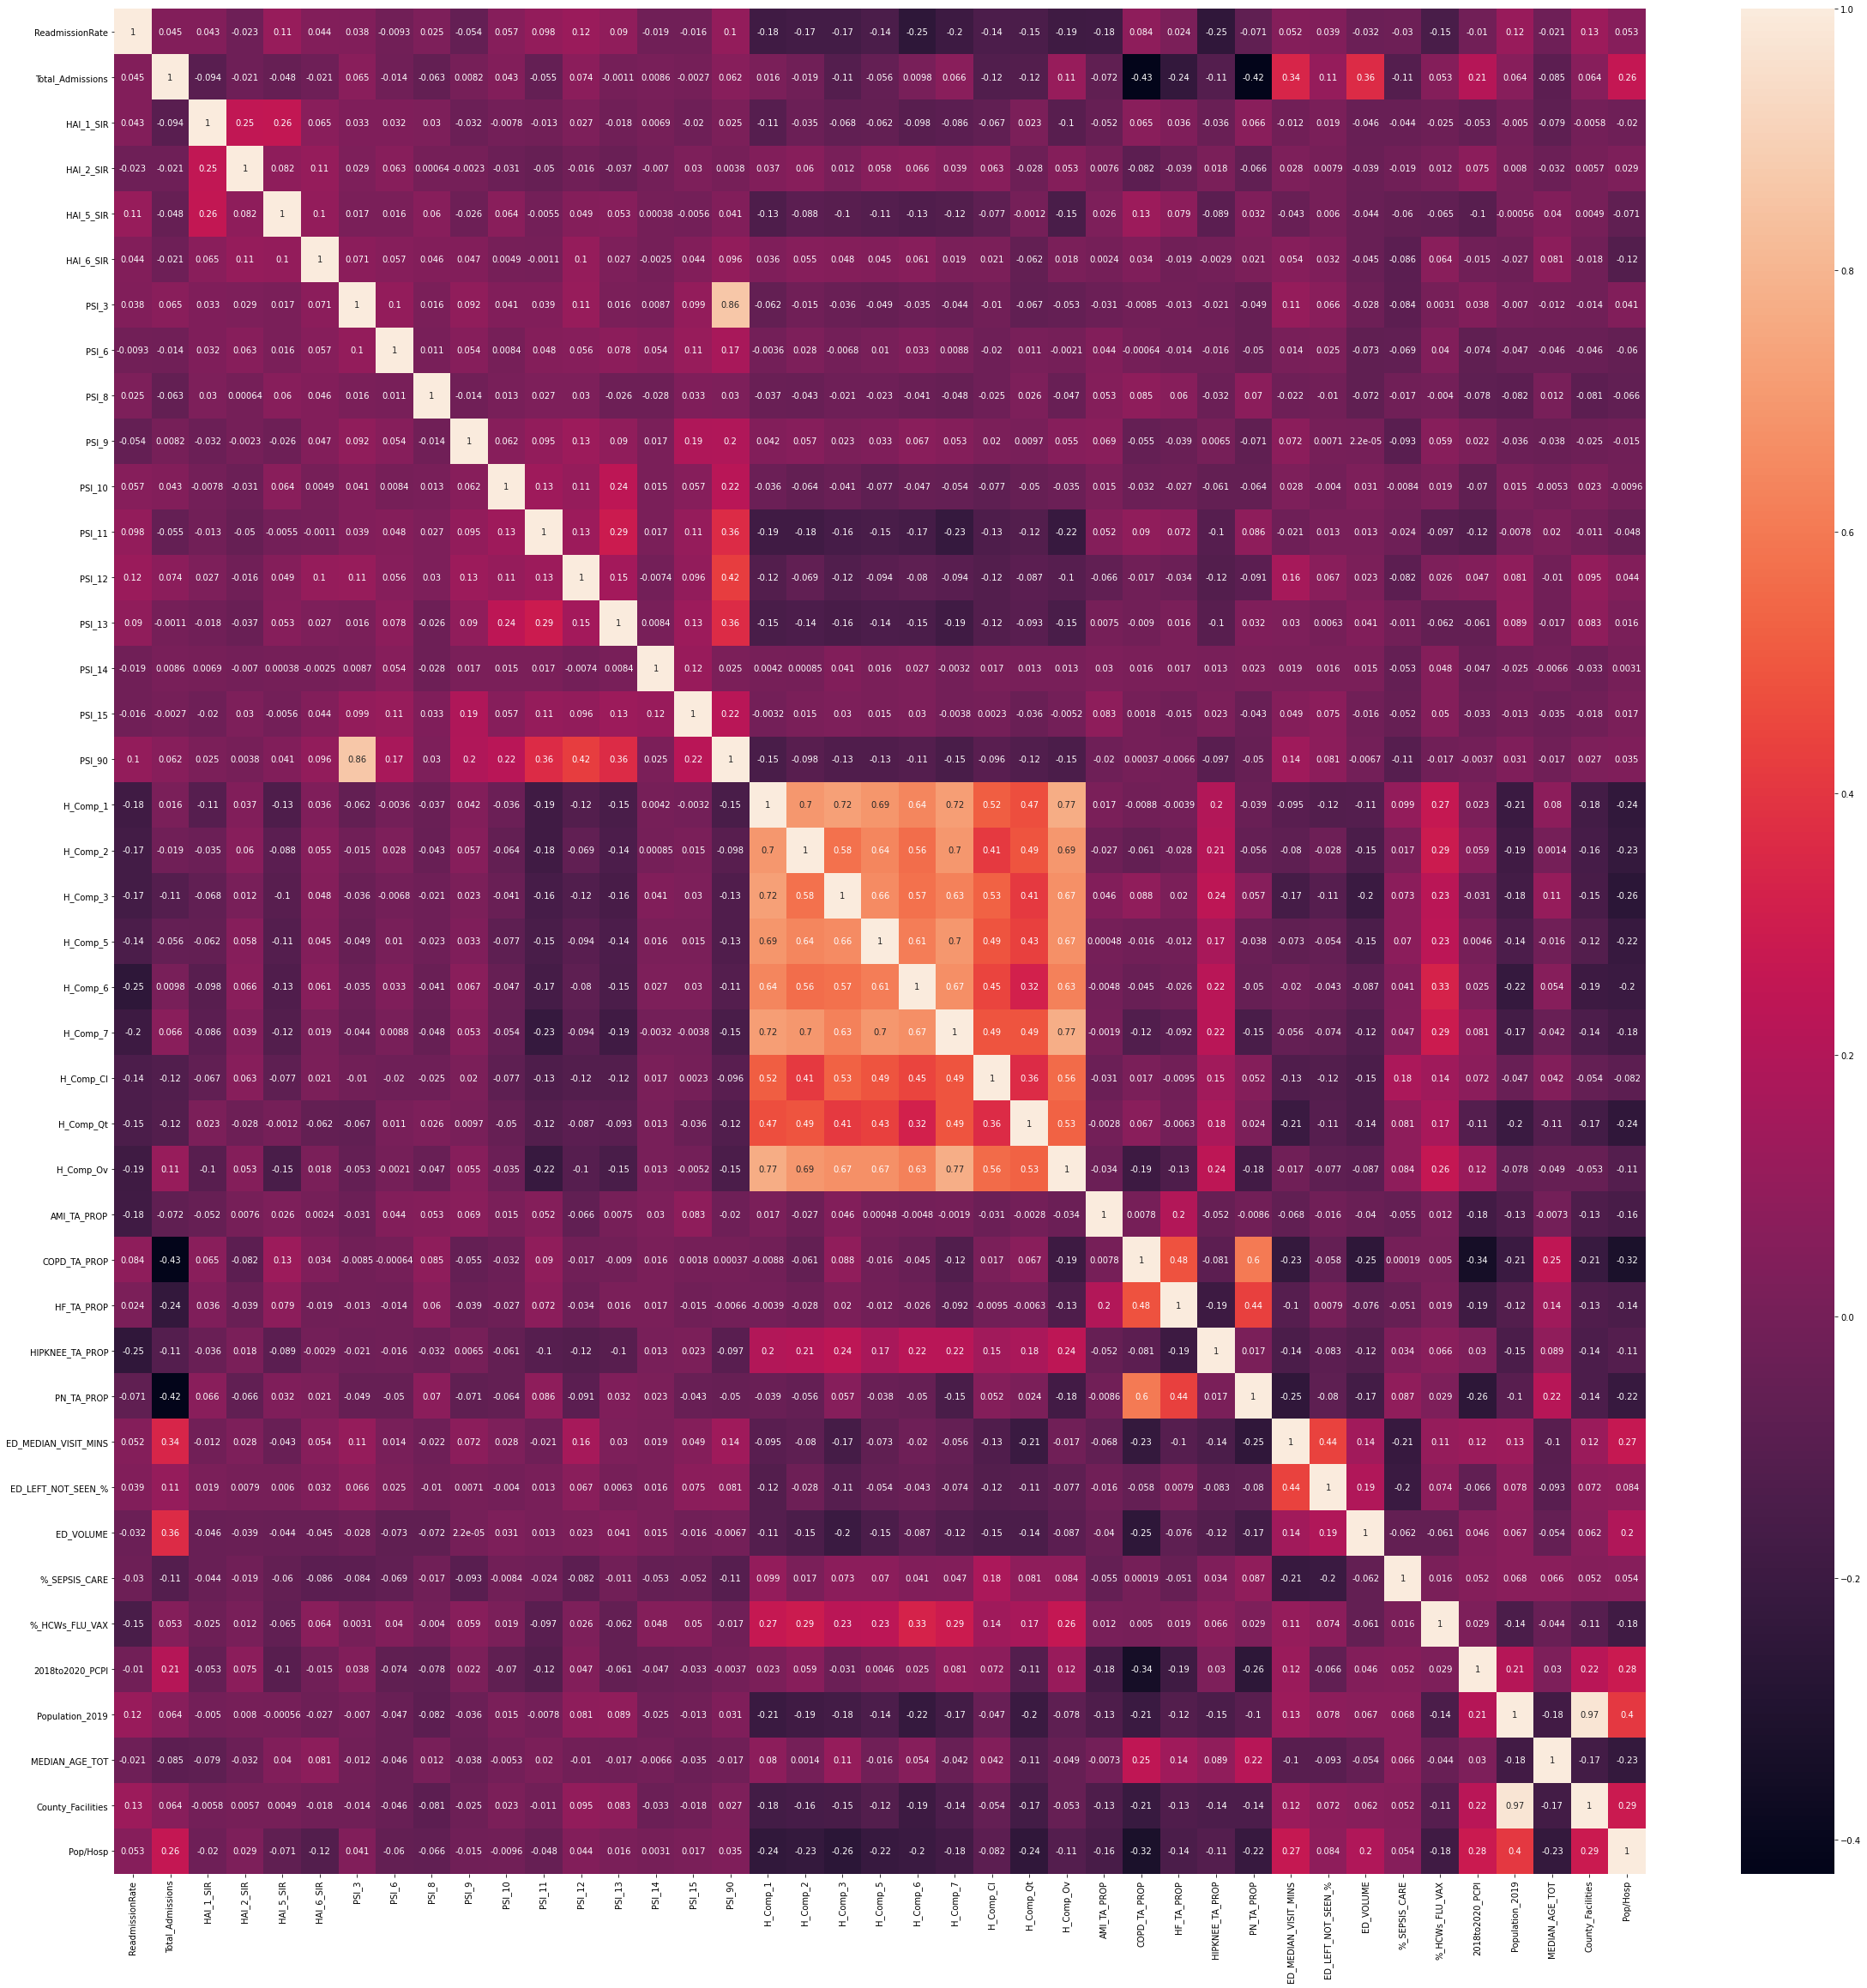

In [19]:
#Heatmap of correlations in main_data
plt.subplots(figsize=(40,40))
sns.heatmap(main_data2.corr(), annot = True);

One thing that pops out immediately on a heatmap is that the H_Comp features (patient survey star ratings) are highly correlated with each other for the most part. This is especially true of the overall hospital rating ('H_Comp_Ov') relative to the component patient survey star ratings. So, at least for the visualization and overall EDA, we will move forward with just H_Comp_Ov from this set of related measures. 

In [20]:
#Create a new df minus the highly correlated component patient survey star rating features
main_data3 = main_data2.drop(['H_Comp_1','H_Comp_2','H_Comp_3','H_Comp_5','H_Comp_6','H_Comp_7','H_Comp_Cl','H_Comp_Qt'], axis=1)
main_data3.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ReadmissionRate       2473 non-null   float64
 1   Facility_ID           2473 non-null   object 
 2   City                  2473 non-null   object 
 3   State                 2473 non-null   object 
 4   County                2473 non-null   object 
 5   Total_Admissions      2473 non-null   int64  
 6   HAI_1_SIR             1949 non-null   float64
 7   HAI_2_SIR             2133 non-null   float64
 8   HAI_5_SIR             1674 non-null   float64
 9   HAI_6_SIR             2320 non-null   float64
 10  PSI_3                 2445 non-null   float64
 11  PSI_6                 2445 non-null   float64
 12  PSI_8                 2445 non-null   float64
 13  PSI_9                 2436 non-null   float64
 14  PSI_10                2335 non-null   float64
 15  PSI_11               

<AxesSubplot:>

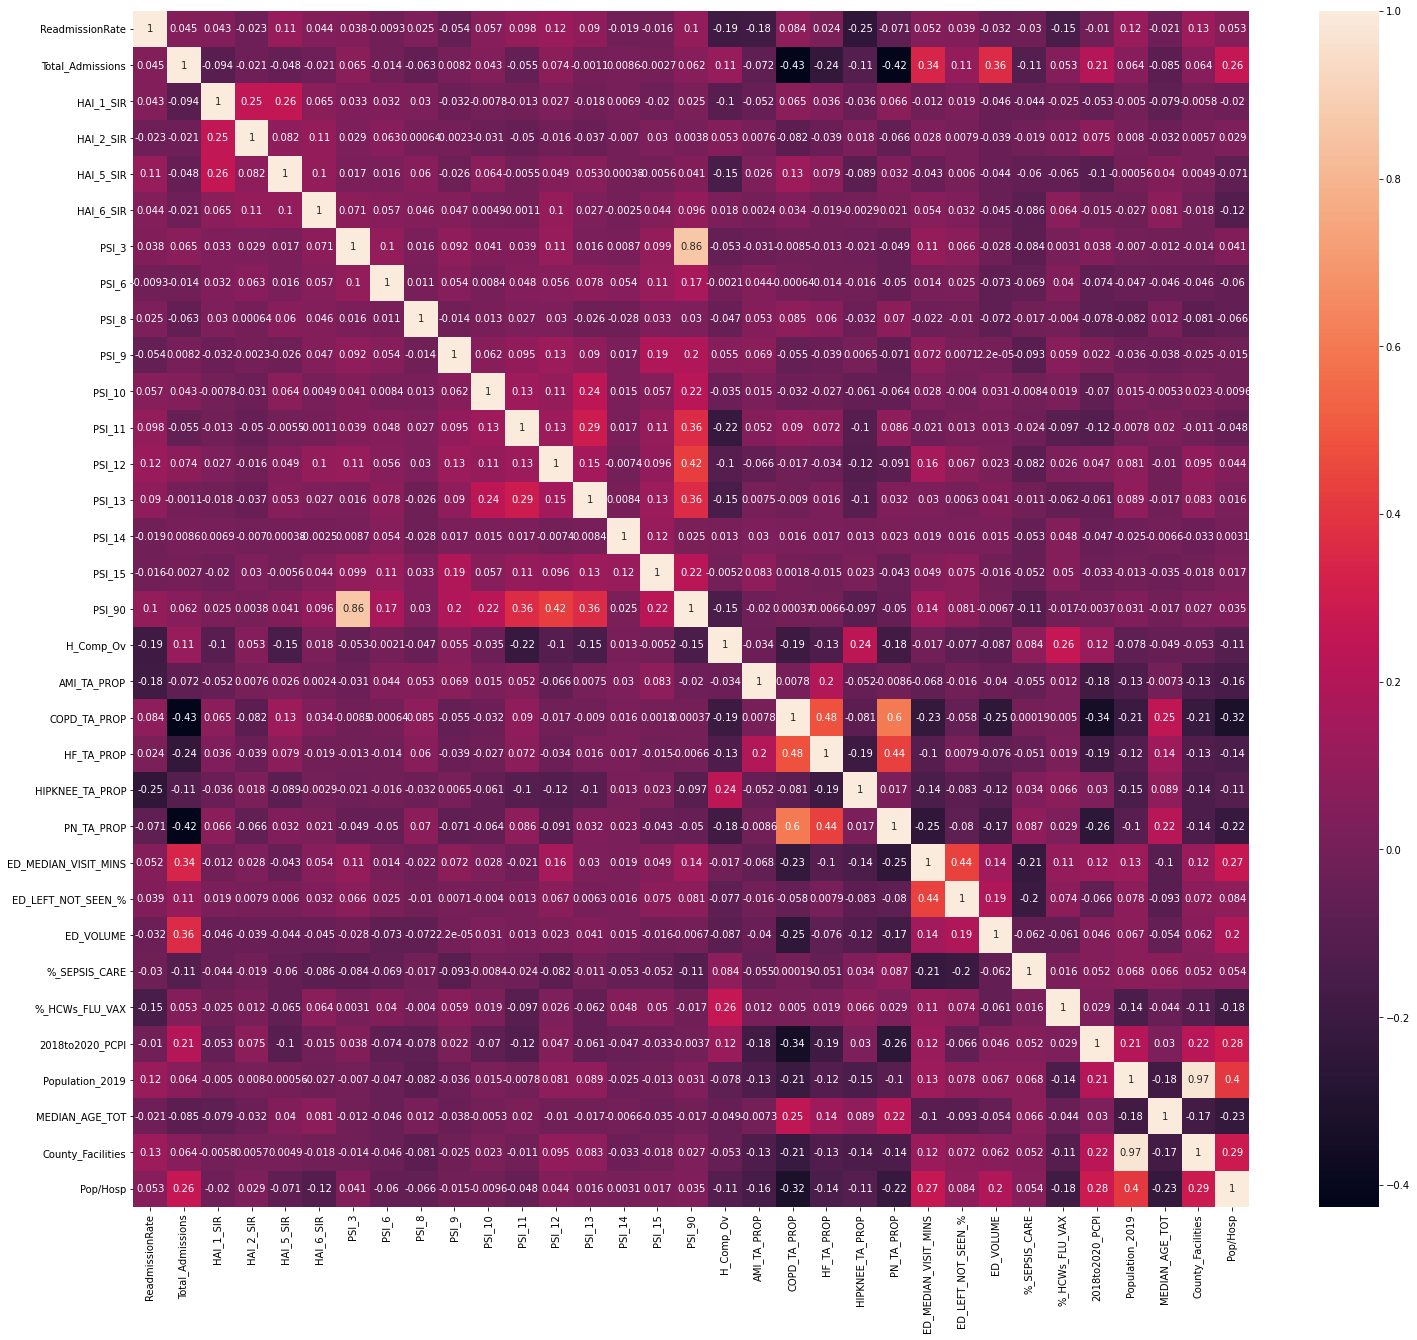

In [21]:
#Recreate Heatmap with the large number of highly correlated patient survey features removed
plt.subplots(figsize=(25,22))
sns.heatmap(main_data3.corr(), annot = True)

We see from the heat map that our target feature doesn't have a particularly strong correlation to any of the individual putative predictive features. 

The strongest positive correlations were:
* County_Facilities: # of hospitals in the same county as a given hospital (.13)
* Population_2019: Population of the county in which a given hospital resides (.12)
* PSI_12: 'Perioperative pulmonary embolism or deep vein thrombosis rate' during initial stay (.12)
* HAI_5_SIR: MRSA Bacteremia infection rate during inpatient stay (.11)
* COPD_TA_Prop: % Initial Inpatient Admissions Due to COPD (not mutually excl.)(.08)

The strongest negative correlations were:
* HIP_Knee_TA_Prop: % Initial Inpatient Admissions Due to Hip/Knee Replacement (not mutually excl.)(-.25)
* H_COMP_Ov: Overall Hospital Rating (Patient Survey Star Rating from Inpatient Stay) (-.19)
* AMI_TA_Prop: % Initial Inpatient Admissions Due to Acute Myocardial Infarction (not mutually excl.)(-.18)
* %_HCWs_FLU_VAX': Percentage of Healthcare Workers Vaccinated by Hospital (-.15)

In [22]:
#Let's look at some scatterplots just of the features we identified as having some correlation to the target (RR)
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'ReadmissionRate', data=main_data3, alpha=0.5)
        ax.set(xlabel=col, ylabel='ReadmissionRate')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        


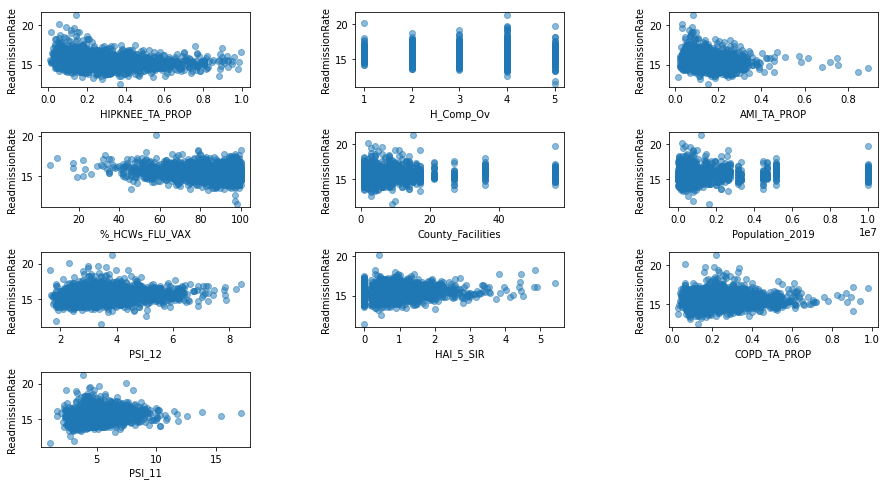

In [23]:
scatterplots(['HIPKNEE_TA_PROP','H_Comp_Ov','AMI_TA_PROP','%_HCWs_FLU_VAX','County_Facilities','Population_2019','PSI_12','HAI_5_SIR','COPD_TA_PROP','PSI_11'], ncol=3)

In [24]:
#Now broad picture of all  features. First, need to exclude non-numeric features from plots
features = [x for x in main_data3.columns if x not in ['Facility_ID', 'City', 'State', 'County']]

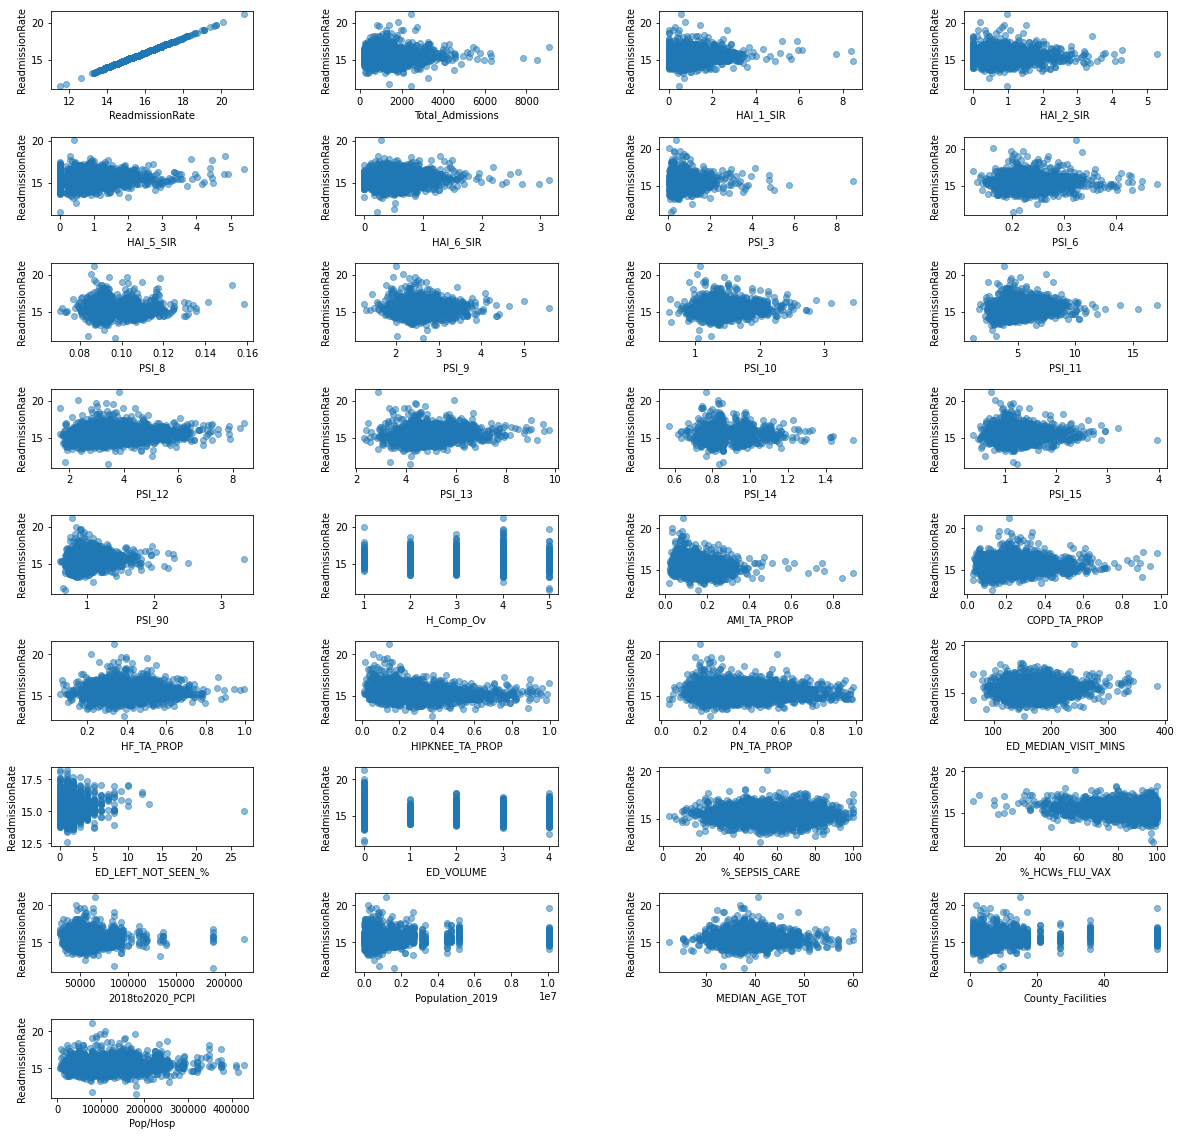

In [25]:
#Plot the putative predictive features vs target feature (RR) for all features
scatterplots(features, ncol=4, figsize=(20, 20))

### 6. Saving Data

In [26]:
#Saving data
main_data3.to_csv('../data/main_df_post2_200.csv', index=False)

### 7. EDA Conclusions

Features Created and Data Transformations:
* Created a new feature ('pop_per_hosp) as a direct measure of inpatient facility density per person. 
    * This new feature, along with 1) inpatient caseload/case mix per hospital; 2) ED caseload/efficiency; and 3) raw population per county, will help round out a picture of how "burdened" hospitals in our sample are. 
    * Computed as ratio of inpatient facilities within the county that a facility is located to the population of the county (county population/# hospitals in the county) 

* We numerically encoded 'ED_VOLUME', previously categorical as such: 0=Missing; 1=low; 2=medium; 3=high; 4=very high

We saw with heat map of correlations our target feature doesn't have a particularly strong correlation to any of the individual putative predictive features. Which of these features will "pop" as important in modeling will be seen in the next step.  
 
The strongest positive correlations were:
* County_Facilities: # of hospitals in the same county as a given hospital (.13)
* Population_2019: Population of the county in which a given hospital resides (.12)
* PSI_12: 'Perioperative pulmonary embolism or deep vein thrombosis rate' during initial stay (.12)
* HAI_5_SIR: MRSA Bacteremia infection rate during inpatient stay (.11)
* COPD_TA_Prop: % Initial Inpatient Admissions Due to COPD (not mutually excl.)(.08)

The strongest negative correlations were:
* HIP_Knee_TA_Prop: % Initial Inpatient Admissions Due to Hip/Knee Replacement (not mutually excl.)(-.22)
* H_COMP_Ov: Overall Hospital Rating (Patient Survey Star Rating from Inpatient Stay) (-.19)
* AMI_TA_Prop: % Initial Inpatient Admissions Due to Acute Myocardial Infarction (not mutually excl.)(-.18)
* %_HCWs_FLU_VAX': Percentage of Healthcare Workers Vaccinated by Hospital (-.15)

Based on the modest correlations at the individual feature level seen in this exploration, it is likely that a more nonlinear model type will bear fruit in prediction of Readmission Rate (RR). However, we will first look at an average-based "dummy" model and Linear Regression modeling before progressing to nonlinear, decision tree-based models (Random Forest, Gradient Boosting [ensemble], HistGradient Boosting [ensemble]). 
